In [2]:
import os
os.chdir('/rd2/user/xiacr/sle/other_sc_data/')

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import harmonypy as hm

import glob
import anndata as ad
import collections

import scanpy.external as sce

In [17]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=160, facecolor='white', fontsize=10)
sc._settings.ScanpyConfig.n_jobs = 32

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.8 pynndescent==0.5.5


In [9]:
file_list = glob.glob('h5ad/*.h5ad')
file_list


['h5ad/EBioMedicine_21.h5ad',
 'h5ad/nc_19_sle_flare.h5ad',
 'h5ad/nbt_17.h5ad',
 'h5ad/nc_19_sle.h5ad',
 'h5ad/natimm_20.h5ad',
 'h5ad/pnas_19.h5ad']

In [ ]:
adatas = []
for file in file_list:
    # print(file.split('/')[1].split('_')[0])
    tmp_adata = sc.read_h5ad(file)
    tmp_adata.var_names_make_unique()
    tmp_adata.obs['batch'] = file.split('/')[1].split('_')[0]
    adatas.append(tmp_adata)

In [ ]:
adata = adatas[0].concatenate(adatas[1:])
adata.obs['batch'].value_counts()
del adatas
adata

## QC

In [15]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],groupby='batch', rotation= 90,
             jitter=0.4, multi_panel=True,)

filtered out 13469 cells that have less than 300 genes expressed


KeyError: "Could not find keys '['sample']' in columns of `adata.obs` or in adata.var_names."

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
# adata = adata[(adata.obs.n_genes_by_counts < 6000) & 
#               (adata.obs.total_counts < 40000) &
#               (adata.obs.pct_counts_mt <20) , :]

In [23]:
adata.obs['batch']

AAACCCAAGGTTCACT-1_1-0    0
AAACCCACACACCTTC-1_1-0    0
AAACCCATCAGTGGGA-1_1-0    0
AAACGAAAGGAACTAT-1_1-0    0
AAACGAACATTGACTG-1_1-0    0
                         ..
TTTGTCACATCACGTA-1_3-5    5
TTTGTCAGTATCTGCA-1_3-5    5
TTTGTCAGTTCAGGCC-1_3-5    5
TTTGTCATCCCTCTTT-1_3-5    5
TTTGTCATCGTCCAGG-1_3-5    5
Name: batch, Length: 1424899, dtype: category
Categories (6, object): ['0', '1', '2', '3', '4', '5']

## single cell normal analysis

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


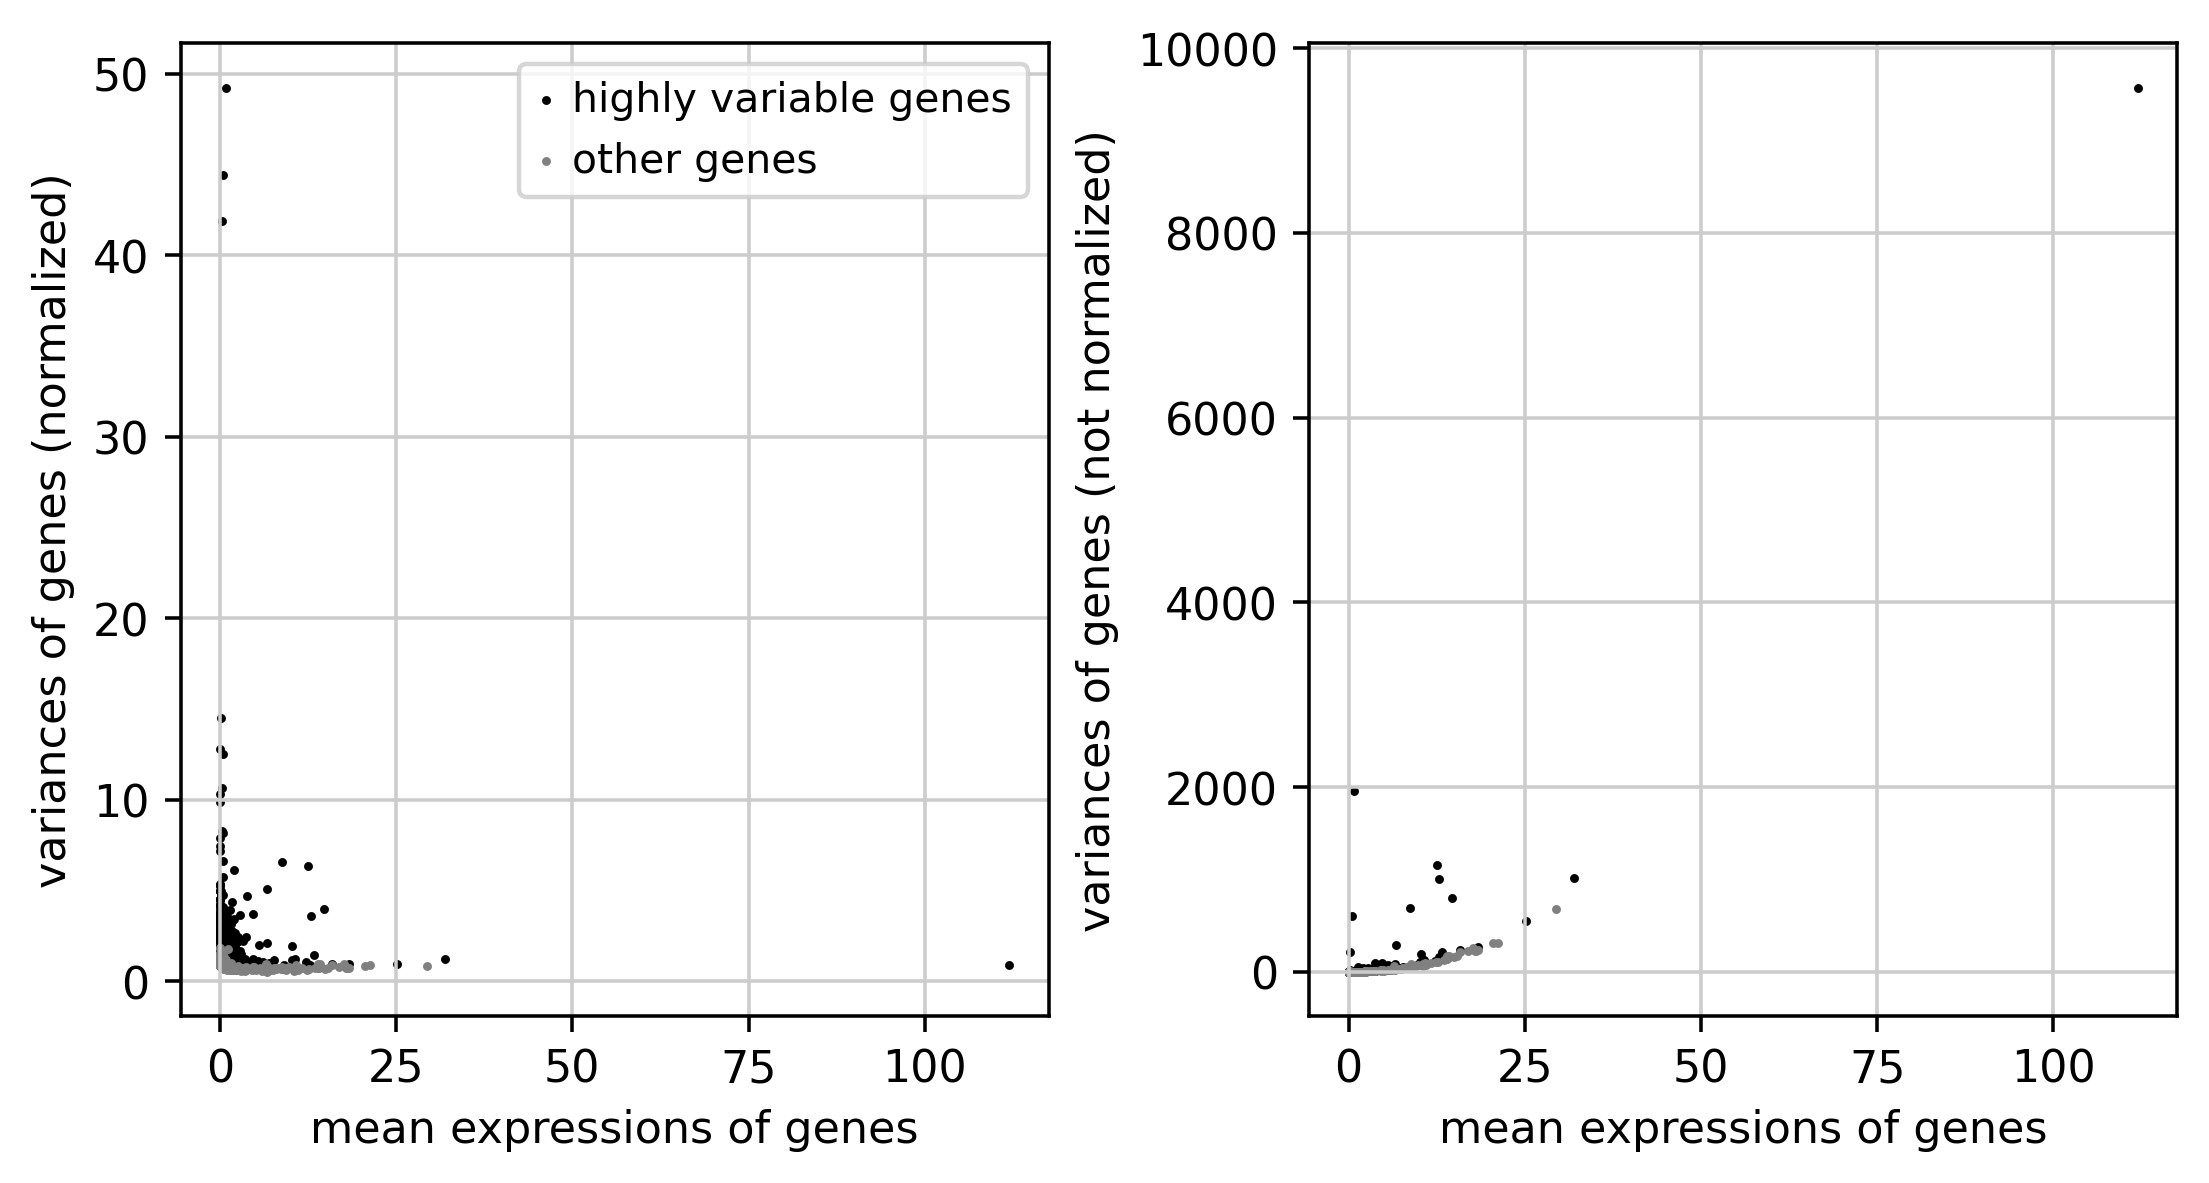

In [25]:
sc.pp.highly_variable_genes(adata, flavor ='seurat_v3',n_top_genes =2500, batch_key ='batch') # must specify n_top_genes when using seurat v3
sc.pl.highly_variable_genes(adata)

In [26]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:06)


In [27]:
adata.raw = adata # You can get back an AnnData of the object in .raw by calling .raw.to_adata().
adata = adata[:, adata.var.highly_variable]

In [28]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # long time

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:06:56)


In [29]:
sc.pp.scale(adata, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:02:44)


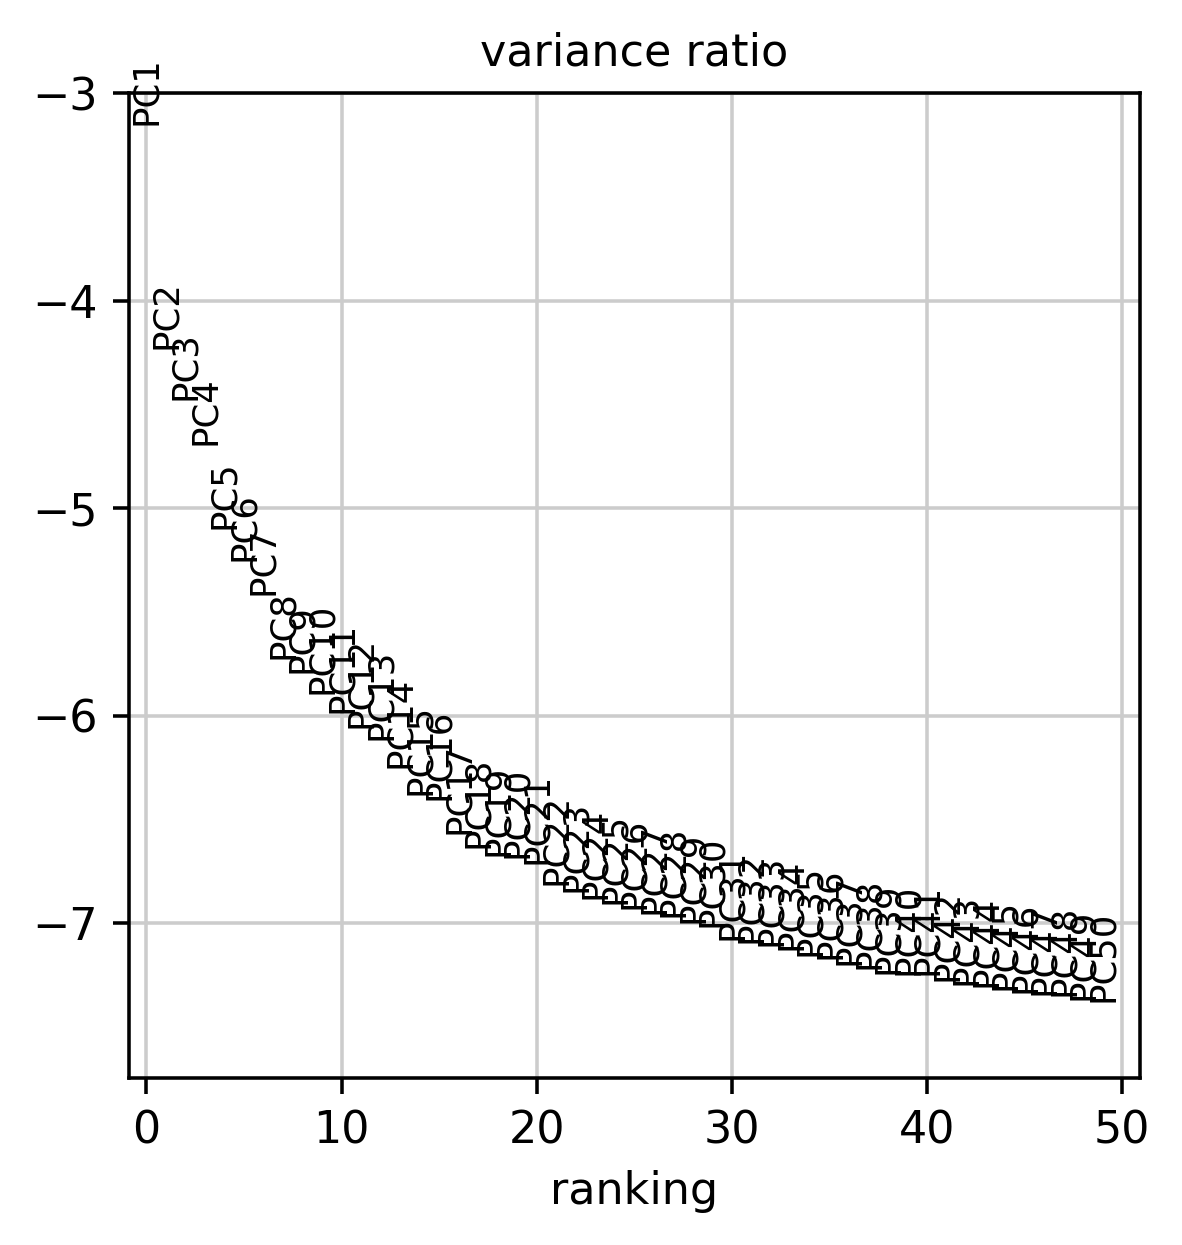

In [30]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs =50)

## Harmony

In [ ]:
hm.run_harmony(data_mat, meta_data, vars_use)

In [34]:
sce.pp.harmony_integrate(adata, 'batch')

2022-01-10 13:46:00,393 - harmonypy - INFO - Iteration 1 of 10
2022-01-10 13:59:18,959 - harmonypy - INFO - Iteration 2 of 10
2022-01-10 14:12:28,704 - harmonypy - INFO - Iteration 3 of 10
2022-01-10 14:25:33,442 - harmonypy - INFO - Iteration 4 of 10
2022-01-10 14:38:42,190 - harmonypy - INFO - Iteration 5 of 10
2022-01-10 14:51:15,161 - harmonypy - INFO - Iteration 6 of 10
2022-01-10 14:57:20,447 - harmonypy - INFO - Converged after 6 iterations


## Cluster and Vis

In [35]:
adata

AnnData object with n_obs × n_vars = 1424899 × 2500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'Run', 'BioSample', 'biospecimen_repository_sample_id', 'Bytes', 'Center.Name', 'Consent_Code', 'Consent', 'DATASTORE.filetype', 'DATASTORE.provider', 'DATASTORE.region', 'Experiment', 'Library.Name', 'Sample.Name', 'sex', 'submitted_subject_id', 'subject_is_affected', 'AvgSpotLen', 'Bases', 'study_disease', 'barcode', 'group', 'percent_mito', 'percent_ribo', 'RNA_snn_res.0.8', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'name-0', 'name-1', 'name-2', 'name-3', 'vst.mean-4', 'vst.variance-4', 'vst.variance.expected-4', 'vst.variance.standardized-4', 'vst.variable-4', 'name-5', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 

In [ ]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,use_rep='X_pca_harmony' )
sc.tl.leiden(adata)

sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:29)
running Leiden clustering


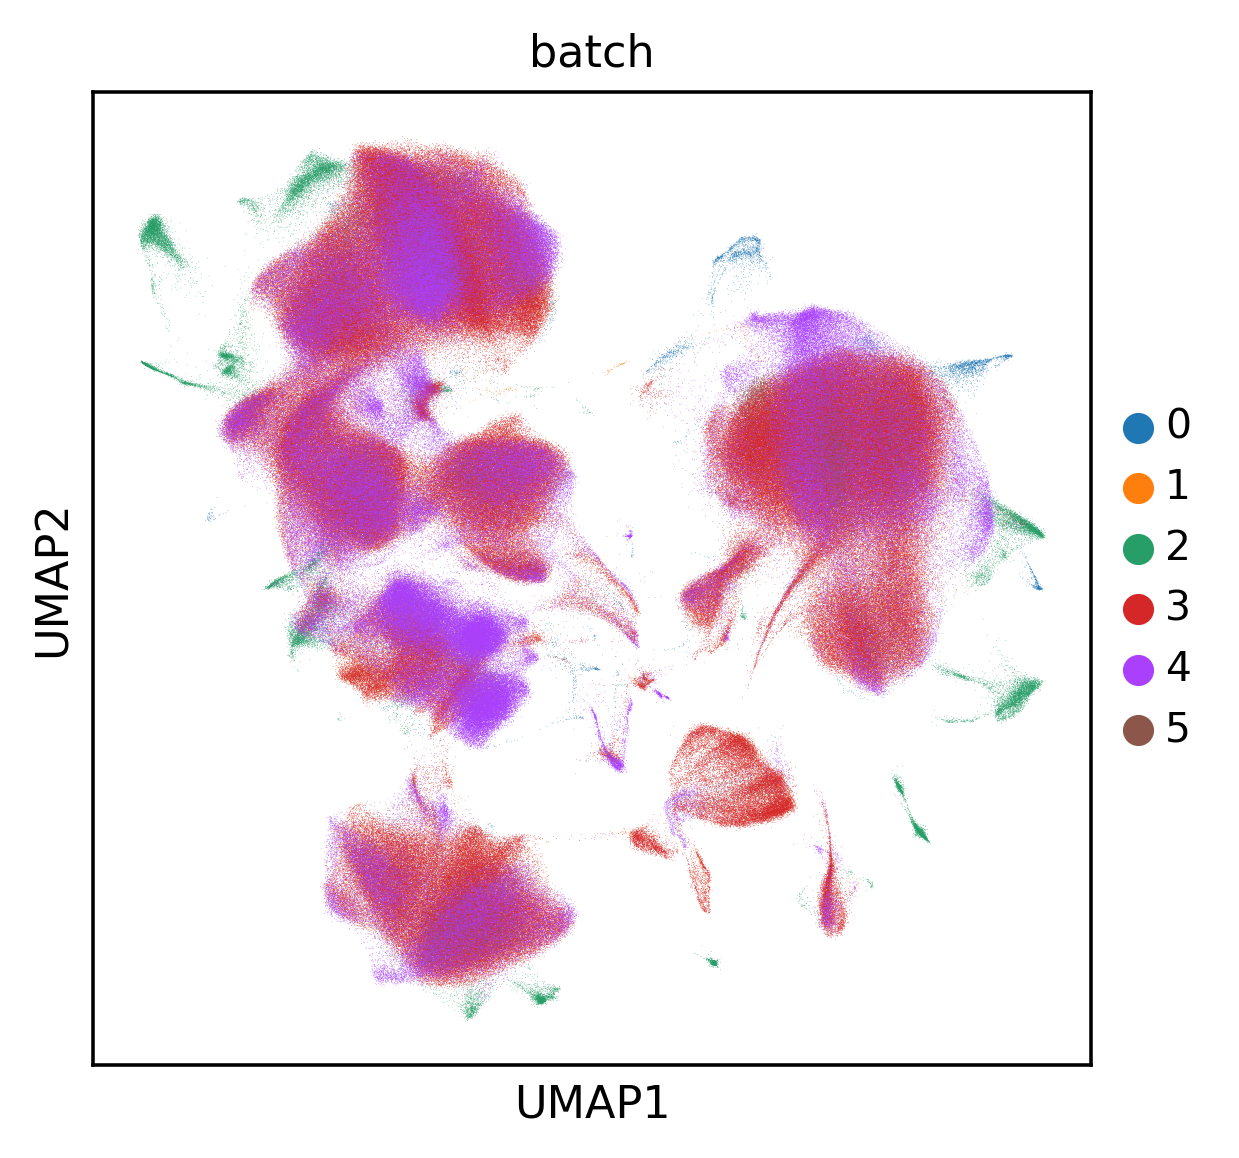

In [39]:
sc.pl.umap(adata,color=['batch'])

,orig.ident,nCount_RNA,nFeature_RNA,batch,Run,BioSample,biospecimen_repository_sample_id,Bytes,Center.Name,Consent_Code,...,G2M.Score,Phase,old.ident,cell_type,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCCAAGGTTCACT-1_1-0,EBioMedicine_21_HC1,3160.0,1289,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1184,1184,3021.0,673.0,22.277391,17
AAACCCACACACCTTC-1_1-0,EBioMedicine_21_HC1,3165.0,1096,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1043,1043,3076.0,219.0,7.119636,14
AAACCCATCAGTGGGA-1_1-0,EBioMedicine_21_HC1,8909.0,2117,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1934,1934,8579.0,364.0,4.242918,8
AAACGAAAGGAACTAT-1_1-0,EBioMedicine_21_HC1,6875.0,2022,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1865,1865,6631.0,610.0,9.199216,10
AAACGAACATTGACTG-1_1-0,EBioMedicine_21_HC1,9385.0,3037,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2831,2831,9012.0,737.0,8.177985,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATCACGTA-1_3-5,PNAS_19_SLE3,3015.0,1121,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1041,1041,2889.0,70.0,2.422984,1
TTTGTCAGTATCTGCA-1_3-5,PNAS_19_SLE3,4020.0,1369,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1276,1276,3880.0,100.0,2.577320,1
TTTGTCAGTTCAGGCC-1_3-5,PNAS_19_SLE3,1463.0,661,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,611,611,1403.0,22.0,1.568068,5
TTTGTCATCCCTCTTT-1_3-5,PNAS_19_SLE3,1769.0,714,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,664,664,1710.0,37.0,2.163743,0
